In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import json

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
sns.set(style="whitegrid")

In [4]:
file_path = 'Data/train.csv'
df = pd.read_csv(file_path)

In [5]:
print("Dataset shape:", df.shape)

Dataset shape: (159571, 8)


In [6]:
print("\nFirst few rows:")
df.head()


First few rows:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
print("\nMissing values per column:")
df.isnull().sum()


Missing values per column:


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [8]:
y_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

C:\Users\gujar\AppData\Local\Temp\ipykernel_13536\819660927.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y_columns, y=y_sum, palette="viridis")


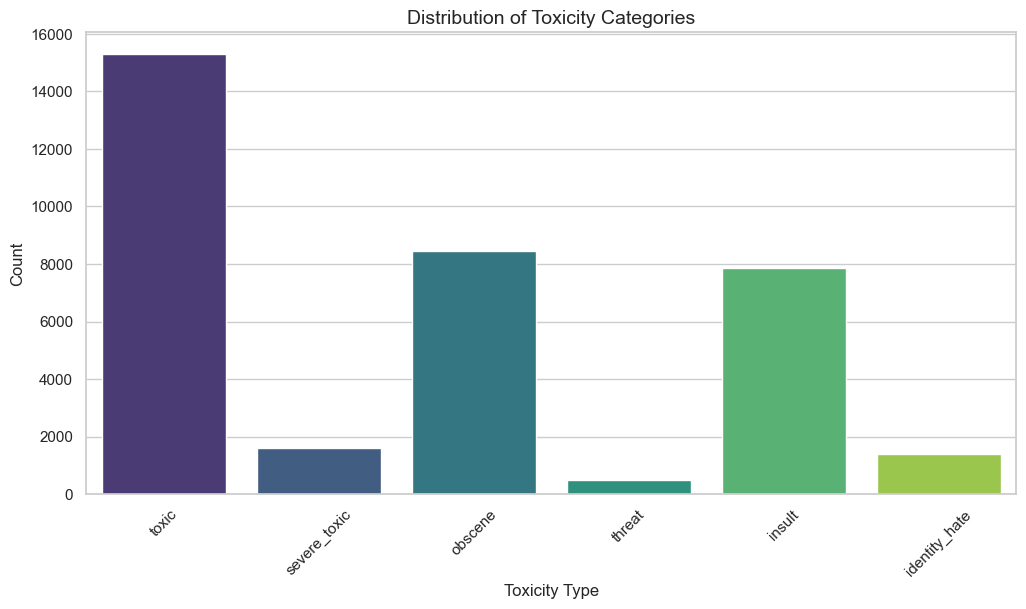

In [9]:
y_sum = df[y_columns].sum()
plt.figure(figsize=(12, 6))
sns.barplot(x=y_columns, y=y_sum, palette="viridis")
plt.title("Distribution of Toxicity Categories", fontsize=14)
plt.xlabel("Toxicity Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [10]:
df['label_sum'] = df[y_columns].sum(axis=1)
num_no_labels = (df['label_sum'] == 0).sum()
num_with_labels = df.shape[0] - num_no_labels

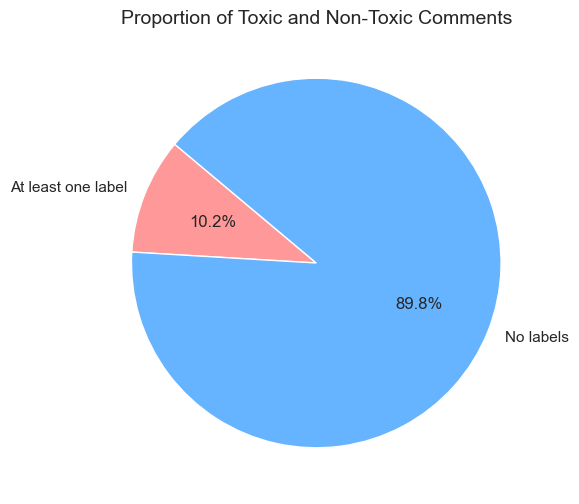

In [11]:
plt.figure(figsize=(6, 6))
plt.pie(
    [num_with_labels, num_no_labels],
    labels=["At least one label", "No labels"],
    autopct='%1.1f%%',
    startangle=140,
    colors=["#ff9999", "#66b3ff"]
)
plt.title("Proportion of Toxic and Non-Toxic Comments", fontsize=14)
plt.show()

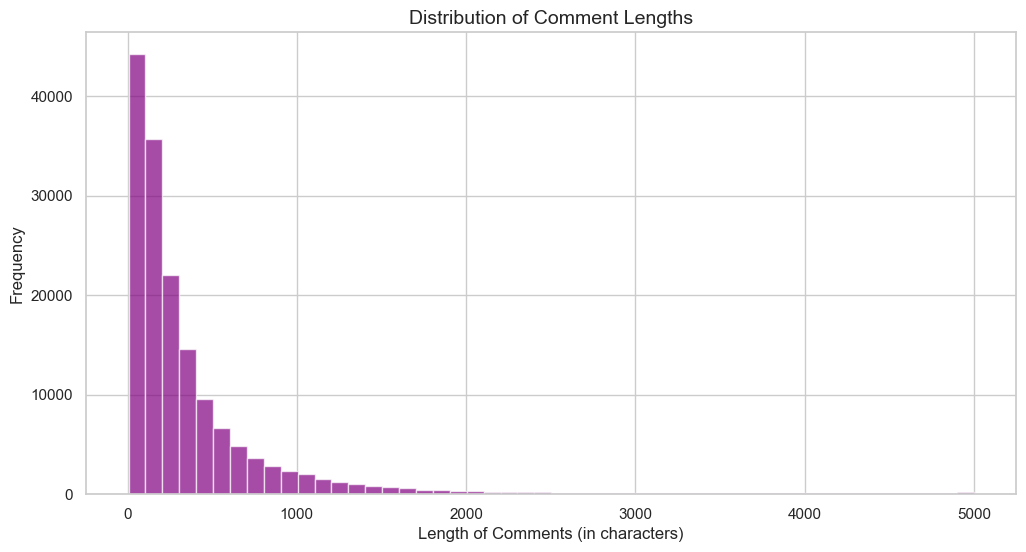

In [12]:
comment_lengths = df['comment_text'].str.len()
plt.figure(figsize=(12, 6))
plt.hist(comment_lengths, bins=50, color='purple', alpha=0.7)
plt.title("Distribution of Comment Lengths", fontsize=14)
plt.xlabel("Length of Comments (in characters)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

In [13]:
all_comments = " ".join(df['comment_text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(all_comments)

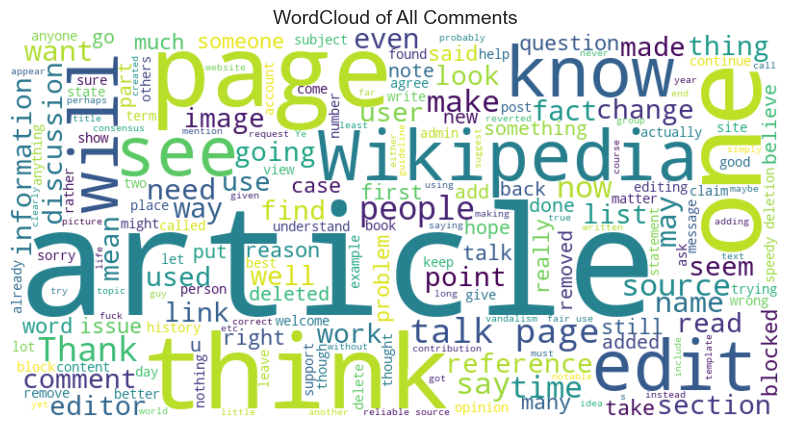

In [14]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of All Comments", fontsize=14)
plt.show()

In [15]:
toxic_comments = df[df['label_sum'] > 0]['comment_text']
toxic_text = " ".join(toxic_comments.dropna())
toxic_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds', max_words=200).generate(toxic_text)

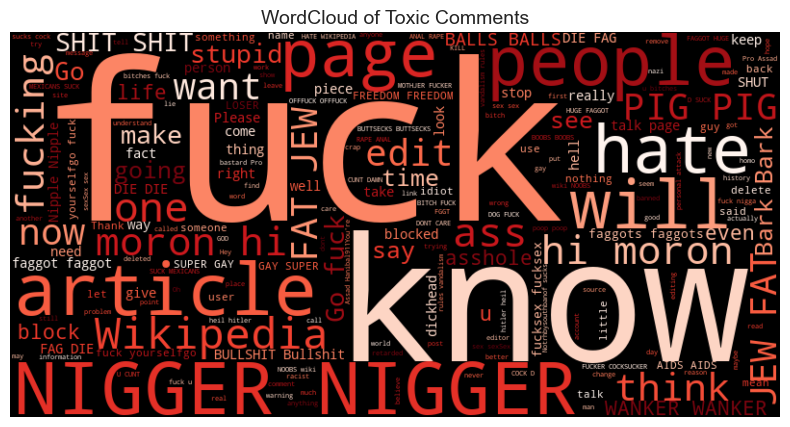

In [16]:
plt.figure(figsize=(10, 5))
plt.imshow(toxic_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of Toxic Comments", fontsize=14)
plt.show()

In [17]:
non_toxic_comments = df[df['label_sum'] == 0]['comment_text']
non_toxic_text = " ".join(non_toxic_comments.dropna())
non_toxic_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues', max_words=200).generate(non_toxic_text)

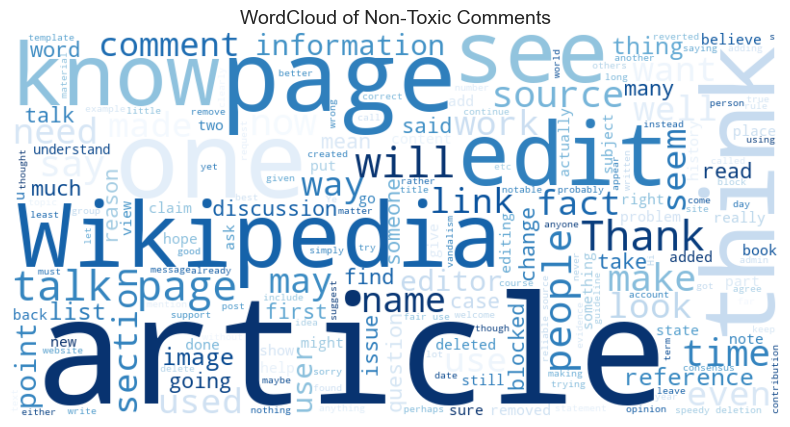

In [18]:
plt.figure(figsize=(10, 5))
plt.imshow(non_toxic_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of Non-Toxic Comments", fontsize=14)
plt.show()

In [19]:
X = df['comment_text']
y_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = df[y_columns].values

In [20]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [21]:
max_features = 20000
max_len = 200
tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

In [22]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [23]:
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')

In [24]:
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as handle:
    json.dump(tokenizer_json, handle)

In [25]:
input_dim = max_features
num_classes = len(y_columns)

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=input_dim, 
                               output_dim=64, 
                               embeddings_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.SpatialDropout1D(0.3),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)
    ),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('comment_toxicity_detection.keras', monitor='val_accuracy', save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

In [29]:
history = model.fit(
    X_train_padded, y_train,
    validation_data=(X_val_padded, y_val),
    epochs=5,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/5
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 213s 60ms/step - accuracy: 0.7780 - loss: 0.2138 - val_accuracy: 0.9939 - val_loss: 0.0872 - learning_rate: 0.0010
Epoch 2/5
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 227s 65ms/step - accuracy: 0.9943 - loss: 0.0952 - val_accuracy: 0.9939 - val_loss: 0.0826 - learning_rate: 0.0010
Epoch 3/5
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 254s 63ms/step - accuracy: 0.9943 - loss: 0.0907 - val_accuracy: 0.9939 - val_loss: 0.0819 - learning_rate: 0.0010
Epoch 4/5
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 315s 90ms/step - accuracy: 0.9943 - loss: 0.0895 - val_accuracy: 0.9939 - val_loss: 0.0856 - learning_rate: 0.0010
Epoch 5/5
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 264s 76ms/step - accuracy: 0.9943 - loss: 0.0881 - val_accuracy: 0.9939 - val_loss: 0.0834 - learning_rate: 0.0010


In [31]:
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

748/748 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9935 - loss: 0.0805

Test Loss: 0.0829
Test Accuracy: 0.9942


In [32]:
model.save('comment_toxicity_detection.h5', save_format='h5')

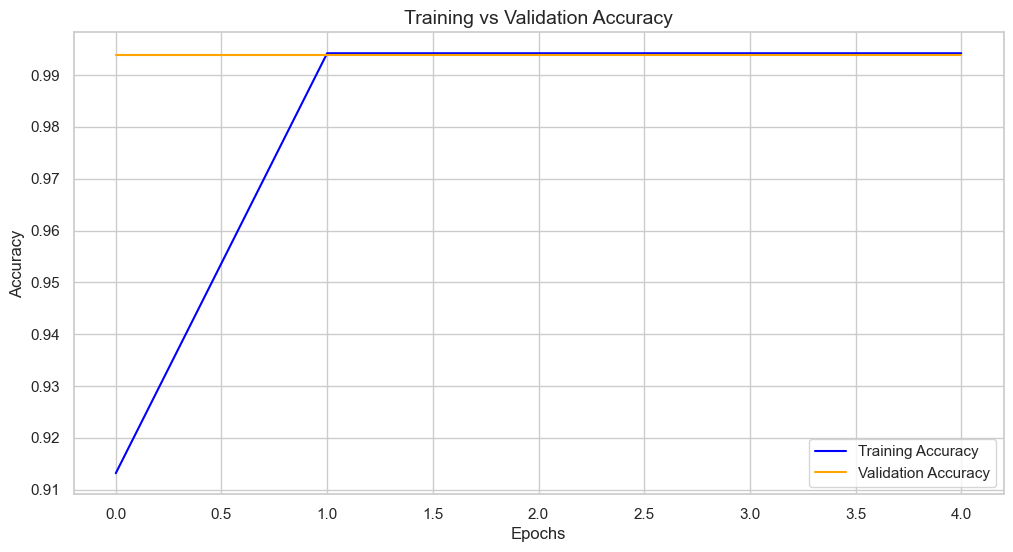

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title("Training vs Validation Accuracy", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.show()

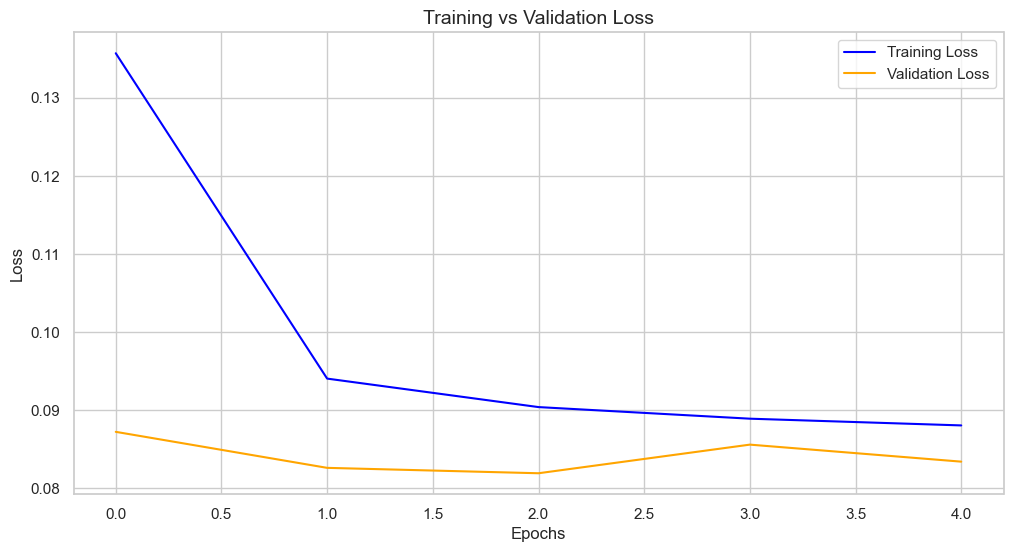

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Training vs Validation Loss", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.show()

In [35]:
y_pred = model.predict(X_test_padded)
y_pred_binary = (y_pred > 0.5).astype(int)

748/748 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step


In [36]:
from sklearn.metrics import classification_report, confusion_matrix

In [37]:
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.64      0.75      2320
           1       0.00      0.00      0.00       246
           2       0.81      0.75      0.78      1293
           3       0.00      0.00      0.00        67
           4       0.73      0.66      0.69      1219
           5       0.00      0.00      0.00       225

   micro avg       0.83      0.61      0.70      5370
   macro avg       0.41      0.34      0.37      5370
weighted avg       0.75      0.61      0.67      5370
 samples avg       0.06      0.05      0.05      5370



c:\Users\gujar\anaconda3\envs\TensorFlow\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gujar\anaconda3\envs\TensorFlow\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gujar\anaconda3\envs\TensorFlow\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


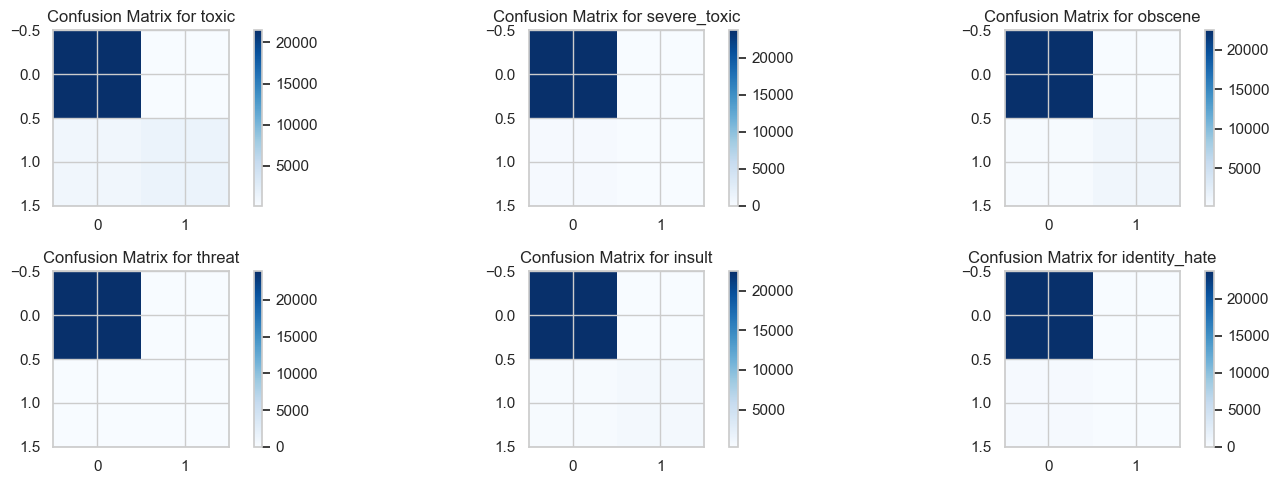

In [38]:
plt.figure(figsize=(15, 5))
for i in range(y_test.shape[1]):
    plt.subplot(2, 3, i+1)
    cm = confusion_matrix(y_test[:, i], y_pred_binary[:, i])
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {y_columns[i]}')
    plt.colorbar()
plt.tight_layout()
plt.show()

In [39]:
loaded_model = tf.keras.models.load_model('comment_toxicity_detection.h5')
with open('tokenizer.json', 'r') as handle:
    tokenizer_json = json.load(handle)
    loaded_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer_json)

In [40]:
sample_comments = ["You are awesome!", "I hate you, you're terrible!", "This is a great community."]
sample_sequences = loaded_tokenizer.texts_to_sequences(sample_comments)
sample_padded = pad_sequences(sample_sequences, maxlen=max_len, padding='post', truncating='post')

In [41]:
predictions = loaded_model.predict(sample_padded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


In [42]:
for comment, pred in zip(sample_comments, predictions):
    print(f"Comment: {comment}")
    for label, score in zip(y_columns, pred):
        print(f"{label}: {round(float(score), 2)} - {'Yes' if score > 0.5 else 'No'}")
    print()

Comment: You are awesome!
toxic: 0.16 - No
severe_toxic: 0.0 - No
obscene: 0.03 - No
threat: 0.0 - No
insult: 0.04 - No
identity_hate: 0.01 - No

Comment: I hate you, you're terrible!
toxic: 0.82 - Yes
severe_toxic: 0.08 - No
obscene: 0.55 - Yes
threat: 0.03 - No
insult: 0.48 - No
identity_hate: 0.08 - No

Comment: This is a great community.
toxic: 0.02 - No
severe_toxic: 0.0 - No
obscene: 0.0 - No
threat: 0.0 - No
insult: 0.0 - No
identity_hate: 0.0 - No

